In [16]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing,metrics
## for explainer
from lime import lime_text\
#for oversampling minority class
from imblearn.over_sampling import SMOTE
!pip install wordcloud
from wordcloud import WordCloud


You should consider upgrading via the '/Users/nidhisoley/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [10]:
!pip install lime
#!pip install transformers

You should consider upgrading via the '/Users/nidhisoley/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
# Combine syncope with loss of consciousness
df=pd.read_csv('vaers_data.csv')
df

,VAERS_ID,STATE,AGE_YRS,SEX,VAX_MANU,SYMPTOM_TEXT,DIED,Asthenia,Chest pain,Chills,...,Pallor,Pruritus,Pyrexia,Rash,Seizure,Syncope,Troponin increased,Unresponsive to stimuli,Urticaria,Vomiting
0,920541,NE,17.0,F,PFIZER\BIONTECH,"DEVELOPED HEADACHE, FEVER, CHILLS, BODY ACHES,...",NaN,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,922534,IN,16.0,F,PFIZER\BIONTECH,"Became dizzy on January 5, 2021",NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,924171,LA,13.0,F,PFIZER\BIONTECH,Late at night patient began having chills and ...,NaN,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,926611,MO,16.0,M,PFIZER\BIONTECH,1/6 a rash developed at the injection site and...,NaN,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,927167,MA,16.0,F,PFIZER\BIONTECH,Entered observation @ 1935. Mother stated to ...,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15767,2233852,MI,11.0,M,PFIZER\BIONTECH,Case-patient had first Pfizer COVID-19 vaccine...,NaN,0,1,0,...,0,0,1,0,0,0,1,0,0,1
15768,2234221,CA,16.0,M,PFIZER\BIONTECH,Got covid booster Pfizer vaccine at 1:30 PM Rt...,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15769,2234228,CT,11.0,F,PFIZER\BIONTECH,12/19/2021 - Pfizer vaccine received 12/20/202...,NaN,0,0,0,...,0,0,1,0,0,0,0,0,0,0
15770,2234244,NM,8.0,F,PFIZER\BIONTECH,"Feb. 14 to March: signs of depression, anxiety...",NaN,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [4]:
df=df[df['VAX_MANU'].isin(['PFIZER\BIONTECH','MODERNA'])][['VAX_MANU','SYMPTOM_TEXT']]


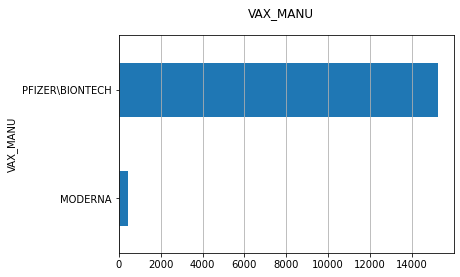

In [5]:
fig, ax = plt.subplots()
fig.suptitle("VAX_MANU", fontsize=12)
df["VAX_MANU"].reset_index().groupby("VAX_MANU").count().sort_values(by= "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()


In [6]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and  characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [7]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [8]:
df["text_clean"] = df["SYMPTOM_TEXT"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df.head()

,VAX_MANU,SYMPTOM_TEXT,text_clean
0,PFIZER\BIONTECH,"DEVELOPED HEADACHE, FEVER, CHILLS, BODY ACHES,...",developed headache fever chill body ache nause...
1,PFIZER\BIONTECH,"Became dizzy on January 5, 2021",became dizzy january 5 2021
2,PFIZER\BIONTECH,Late at night patient began having chills and ...,late night patient began chill extreme muscle ...
3,PFIZER\BIONTECH,1/6 a rash developed at the injection site and...,16 rash developed injection site 17 spread bel...
4,PFIZER\BIONTECH,Entered observation @ 1935. Mother stated to ...,entered observation 1935 mother stated nurse 1...


In [9]:
## split dataset
df_train, df_test = model_selection.train_test_split(df, test_size=0.3,stratify=df['VAX_MANU'],random_state=0)
## get target
y_train = df_train["VAX_MANU"].values
y_test = df_test["VAX_MANU"].values

## Count Vectorizer

In [23]:
## Count (classic BoW)
vectorizer_count = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

In [24]:
corpus = df_train["text_clean"]
vectorizer_count.fit(corpus)
X_train_count = vectorizer_count.transform(corpus)
dic_vocabulary = vectorizer_count.vocabulary_

Text(0.5, 1.0, 'Sparse Matrix Sample')

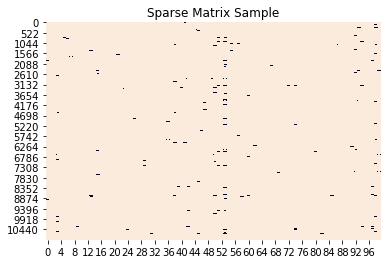

In [25]:
sns.heatmap(X_train_count.todense()[:,np.random.randint(0,X_train_count.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [26]:
classifier = naive_bayes.MultinomialNB()

In [27]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer_count),("classifier", classifier)])
## train classifier
model['classifier'].fit(X_train_count, y_train)
## test
X_test = df_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.98
Auc: 0.91
Detail:
                 precision    recall  f1-score   support

        MODERNA       0.58      0.70      0.64       131
PFIZER\BIONTECH       0.99      0.99      0.99      4567

       accuracy                           0.98      4698
      macro avg       0.79      0.84      0.81      4698
   weighted avg       0.98      0.98      0.98      4698



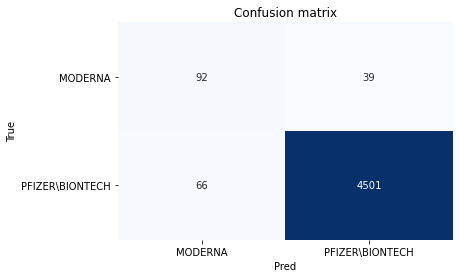

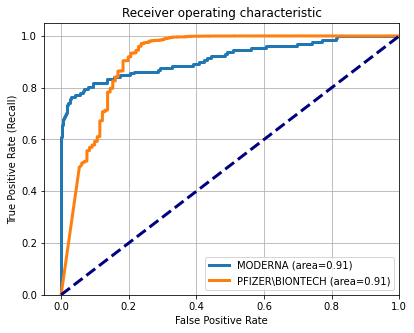

In [28]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax.plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax.set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax.legend(loc="lower right")
ax.grid(True)

In [46]:
## select observation
i = 5
txt_instance = df_test["SYMPTOM_TEXT"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[:,1][i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)


True: PFIZER\BIONTECH --> Pred: PFIZER\BIONTECH | Prob: 1.0


In [19]:
from PIL import Image
#Function to Create Wordcloud
def create_wordcloud(text):
#     stopwords = set(STOPWORDS)
    wc = WordCloud(background_color='black', max_words=3000, repeat=True,colormap='Set2')
    wc.generate(str(text))
    wc.to_file('wc.png')
    path='wc.png'
    display(Image.open(path))

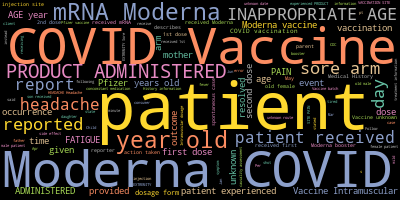

In [20]:
#Creating wordcloud for moderna
mod=df_test[df_test['VAX_MANU']=='MODERNA']
create_wordcloud(mod['SYMPTOM_TEXT'].values)

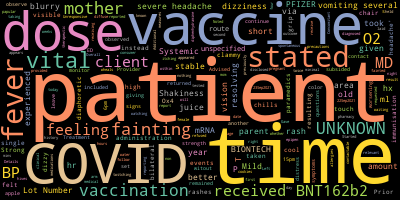

In [21]:
#Creating wordcloud for moderna
pf=df_test[df_test['VAX_MANU']=='PFIZER\BIONTECH']
create_wordcloud(pf['SYMPTOM_TEXT'].values)

 ## TfIdf

In [52]:
## Tf-Idf (advanced variant of BoW)
vectorizer_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [53]:
corpus = df_train["text_clean"]
vectorizer_tfidf.fit(corpus)
X_train_tfidf = vectorizer_tfidf.transform(corpus)
dic_vocabulary = vectorizer_tfidf.vocabulary_

Text(0.5, 1.0, 'Sparse Matrix Sample')

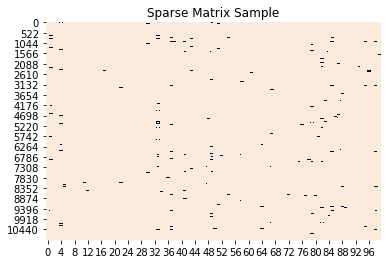

In [54]:
sns.heatmap(X_train_tfidf.todense()[:,np.random.randint(0,X_train_tfidf.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [55]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer_tfidf),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train_tfidf, y_train)
## test
X_test = df_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.98
Auc: 0.9
Detail:
                 precision    recall  f1-score   support

        MODERNA       1.00      0.29      0.45       131
PFIZER\BIONTECH       0.98      1.00      0.99      4567

       accuracy                           0.98      4698
      macro avg       0.99      0.65      0.72      4698
   weighted avg       0.98      0.98      0.97      4698



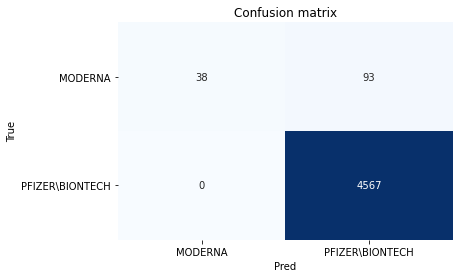

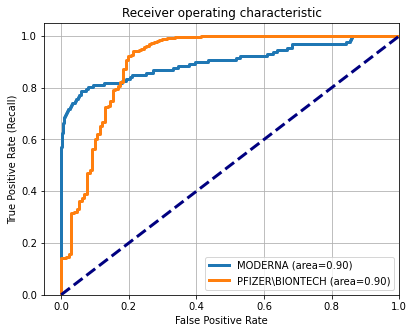

In [56]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax.plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax.set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax.legend(loc="lower right")
ax.grid(True)

In [57]:
## select observation
i = 0
txt_instance = df_test["SYMPTOM_TEXT"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=2)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: PFIZER\BIONTECH --> Pred: PFIZER\BIONTECH | Prob: 0.98


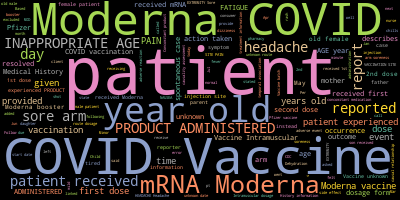

In [58]:
#Creating wordcloud for moderna
mod=df_test[df_test['VAX_MANU']=='MODERNA']
create_wordcloud(mod['SYMPTOM_TEXT'].values)

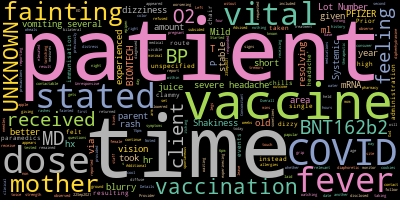

In [59]:
#Creating wordcloud for moderna
pf=df_test[df_test['VAX_MANU']=='PFIZER\BIONTECH']
create_wordcloud(pf['SYMPTOM_TEXT'].values)